# Pipeline

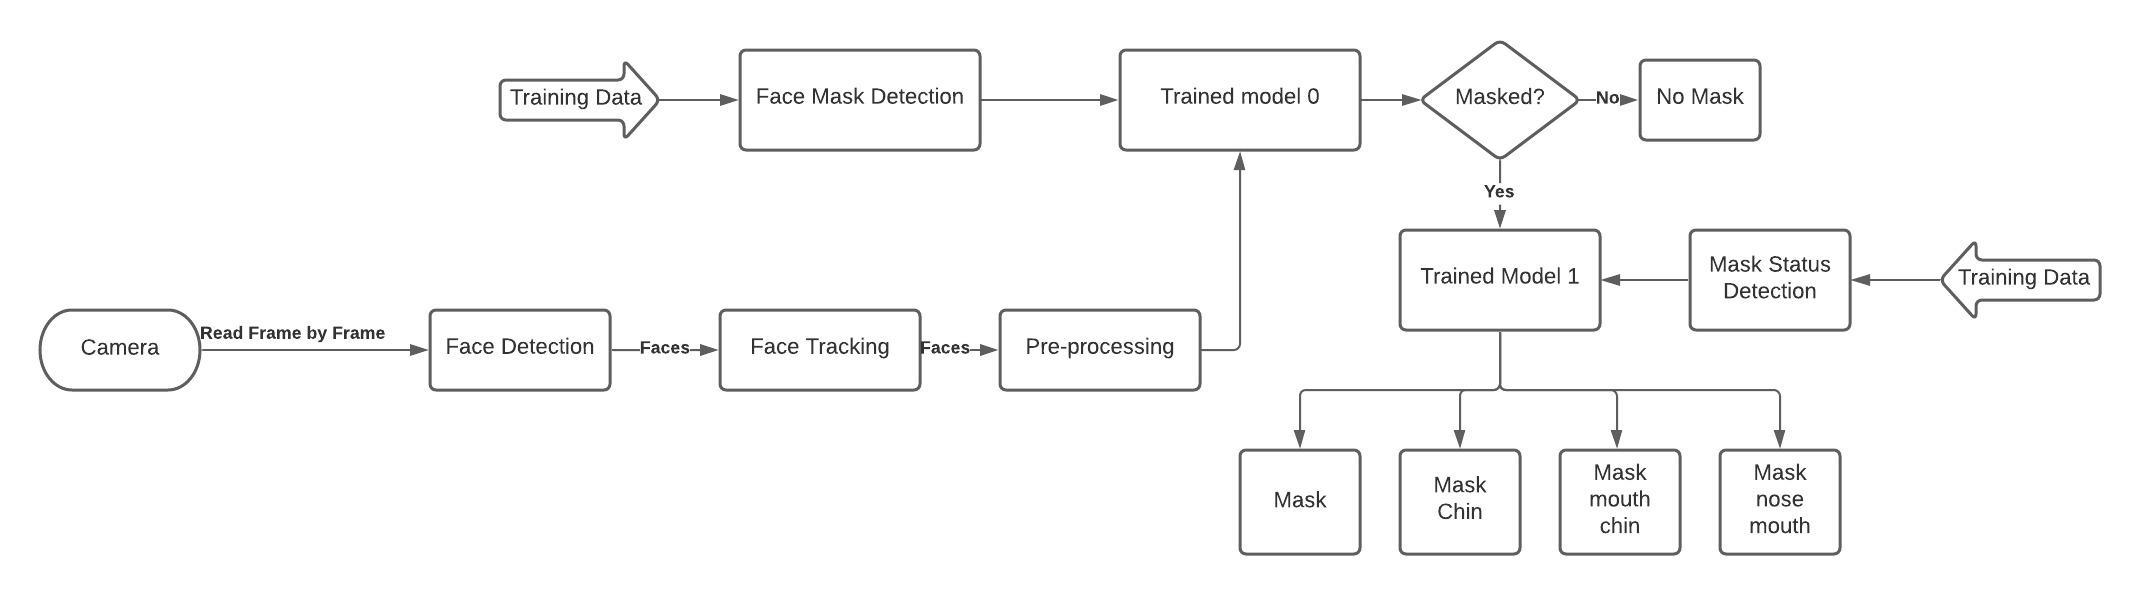

In [1]:
import os
import random 
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from glob import glob
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Flatten, Dropout
from sklearn.metrics import confusion_matrix
import seaborn as sns
import keras

#Dataset


### Downloading and Extracting dataset

In [2]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1pPYFD9HwBJqxpaQg5E6K5EcXOWFSshCX'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('archive.zip')

In [3]:
!mkdir /content/face_mask_detection
!unzip -q /content/archive.zip -d /content/face_mask_detection

In [4]:
DATASET_DIR = os.path.join("/content", "face_mask_detection")

data = [y for x in os.walk(DATASET_DIR) for y in glob(os.path.join(x[0], '*jpg'))]
labels = [os.path.basename(os.path.dirname(x)) for x in data]
print(len(data))

7553


### Displaying a list of data and labels

In [5]:
data[:10]

['/content/face_mask_detection/data/with_mask/with_mask_1071.jpg',
 '/content/face_mask_detection/data/with_mask/with_mask_976.jpg',
 '/content/face_mask_detection/data/with_mask/with_mask_1635.jpg',
 '/content/face_mask_detection/data/with_mask/with_mask_3590.jpg',
 '/content/face_mask_detection/data/with_mask/with_mask_1563.jpg',
 '/content/face_mask_detection/data/with_mask/with_mask_885.jpg',
 '/content/face_mask_detection/data/with_mask/with_mask_3272.jpg',
 '/content/face_mask_detection/data/with_mask/with_mask_2339.jpg',
 '/content/face_mask_detection/data/with_mask/with_mask_2742.jpg',
 '/content/face_mask_detection/data/with_mask/with_mask_1330.jpg']

In [6]:
unique_val, counts = np.unique(labels, return_counts=True)
print(unique_val, counts)

['with_mask' 'without_mask'] [3725 3828]


### Data pre-procesing

### Displaying random images from the dataset

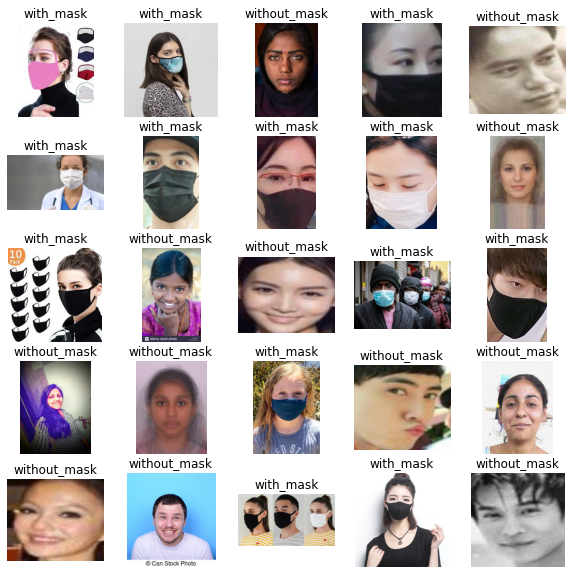

In [7]:
# Sample 25 images from dataset
indices = np.random.randint(0, len(data), size=25)
pt_images = [data[i] for i in indices]
pt_labels = [labels[i] for i in indices]

# Plot the 25 images
plt.figure(figsize=(10,10))
for i in range(len(indices)):
    plt.subplot(5, 5, i + 1)
    image = mpimg.imread(pt_images[i]) # Read image from disk
    plt.imshow(image)
    plt.title(pt_labels[i])
    plt.axis('off')
    
plt.show()

###splitting the dataset into training and test sets (80-20 ratio)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=10)

In [9]:
data_train = np.append(np.array(X_train).reshape(-1,1),np.array(y_train).reshape(-1,1), axis=1)
data_test = np.append(np.array(X_test).reshape(-1,1),np.array(y_test).reshape(-1,1), axis=1)

In [10]:
df_train = pd.DataFrame (data_train,columns=['image', 'label'])
df_test = pd.DataFrame (data_test,columns=['image', 'label'])

In [11]:
df_train.head(5)

,image,label
0,/content/face_mask_detection/data/with_mask/wi...,with_mask
1,/content/face_mask_detection/data/without_mask...,without_mask
2,/content/face_mask_detection/data/with_mask/wi...,with_mask
3,/content/face_mask_detection/data/with_mask/wi...,with_mask
4,/content/face_mask_detection/data/with_mask/wi...,with_mask


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Face Mask distribution')

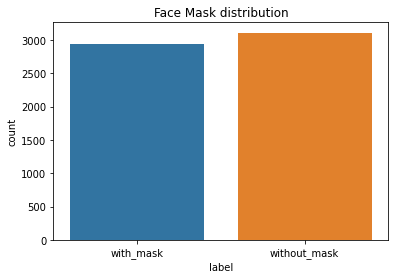

In [12]:
sns.countplot('label', data=df_train)
plt.title("Face Mask distribution")

### Load Images

In [13]:
BATCH_SIZE = 64
HEIGHT = 224
WIDTH = 224
VAL_SPLIT = 0.2

# 1. Construct an instance of the `ImageDataGenerator` class
train_datagen =  ImageDataGenerator(
      preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input,
      width_shift_range=0.2,
      height_shift_range=0.2,
      rotation_range=35,
      zoom_range=[0.8,1.2],
      brightness_range=[0.6,1.2],
      horizontal_flip=True,
      validation_split = VAL_SPLIT
    )



In [14]:
# 2. Retrieve the iterator
train_generator = train_datagen.flow_from_dataframe(df_train,
                                                    x_col='image',
                                                    y_col='label',
                                                    shuffle = True,
                                                    seed = 10,
                                                    target_size=(HEIGHT, WIDTH), 
                                                    batch_size=BATCH_SIZE,
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                    subset='training')
val_generator = train_datagen.flow_from_dataframe(df_train,
                                                  x_col='image',
                                                  y_col='label',
                                                  target_size=(HEIGHT, WIDTH),
                                                  batch_size=BATCH_SIZE,
                                                  shuffle = True,
                                                  seed = 10,
                                                  color_mode='rgb',
                                                  class_mode='categorical',
                                                  subset='validation')

Found 4834 validated image filenames belonging to 2 classes.
Found 1208 validated image filenames belonging to 2 classes.


In [15]:
# Do the same steps for the test set

# 1. Construct an instance of the `ImageDataGenerator` class
test_datagen =  ImageDataGenerator(
    preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input
    )

# 2. Retrieve the iterator
test_generator = test_datagen.flow_from_dataframe(df_test,
                                                  x_col='image',
                                                  y_col='label', 
                                                  target_size=(HEIGHT, WIDTH), 
                                                  batch_size=BATCH_SIZE,
                                                  color_mode='rgb',
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 1511 validated image filenames belonging to 2 classes.


#Model

### Download MobileNet version2 base model

In [34]:
# Load the pretained model
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(HEIGHT, WIDTH, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

### Building our model
- I deactivated all convolutional layers, not to be re-trained.
- Added a fully connected layer with one dense layer and one drop out layer with rate 0.5 
-an output layer with 2 outputs, to accomodate for the 2 classes
- Used RMSprop optimizer
-Learning rate of 0.001

In [31]:
# Use a Sequential model to add a trainable classifier on top
model = keras.Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dense(2, activation='softmax')
])
# Compile
base_learning_rate = 0.001
model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate = base_learning_rate),
            loss = 'categorical_crossentropy',
            metrics = ['accuracy'])

In [28]:
#model.build((None,HEIGHT, WIDTH, 3))

In [35]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_4 (ModuleWrap (None, 1280)              2257984   
_________________________________________________________________
flatten_4 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 512)               655872    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 514       
Total params: 3,045,698
Trainable params: 787,714
Non-trainable params: 2,257,984
______________________________________

#Training

In [32]:
INITIAL_EPOCHS = 10

history = model.fit(train_generator,
                    validation_data = val_generator,
                    epochs = INITIAL_EPOCHS)

Epoch 1/10
11/76 [===>..........................] - ETA: 50s - loss: 2.1446 - accuracy: 0.5949

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


76/76 [==============================] - 89s 1s/step - loss: 0.8040 - accuracy: 0.8216 - val_loss: 0.0648 - val_accuracy: 0.9760
Epoch 2/10
76/76 [==============================] - 78s 1s/step - loss: 0.1230 - accuracy: 0.9576 - val_loss: 0.0757 - val_accuracy: 0.9719
Epoch 3/10
76/76 [==============================] - 77s 1s/step - loss: 0.1087 - accuracy: 0.9679 - val_loss: 0.0640 - val_accuracy: 0.9801
Epoch 4/10
76/76 [==============================] - 77s 1s/step - loss: 0.0652 - accuracy: 0.9777 - val_loss: 0.0673 - val_accuracy: 0.9785
Epoch 5/10
76/76 [==============================] - 77s 1s/step - loss: 0.0719 - accuracy: 0.9768 - val_loss: 0.0661 - val_accuracy: 0.9826
Epoch 6/10
76/76 [==============================] - 76s 1s/step - loss: 0.0707 - accuracy: 0.9776 - val_loss: 0.0597 - val_accuracy: 0.9785
Epoch 7/10
76/76 [==============================] - 77s 1s/step - loss: 0.0714 - accuracy: 0.9741 - val_loss: 0.0758 - val_accuracy: 0.9785
Epoch 8/10
76/76 [=============

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The model has a really high expected accuracy of about 99.5%. It soes not seem to be overfitting or underfitting as the accuracy reached 99.06% on training data, and 99.42% on the validation data

## Saving the model

In [ ]:
#Saving the model to be used later
model.save('/content/drive/MyDrive/Colab Notebooks/Face_Mask_Detection/model1_inception_assets', save_format='hdf5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/Face_Mask_Detection/model1_inception_assets/assets


### Plotting learning curves

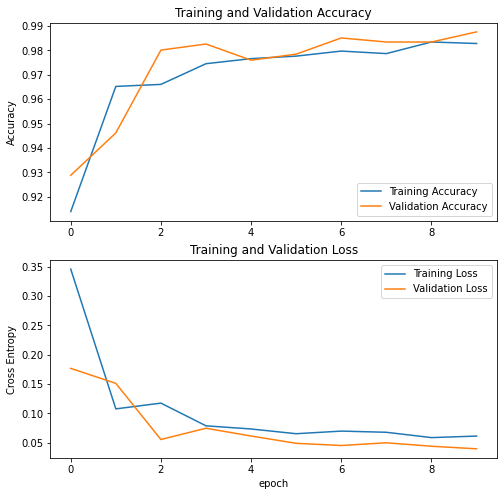

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
#plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

From the learning curves shown above, the model is astonishingly stable. Validation and training accuracy and loss are very near. The model accuracy is high enough to accept. 

#Evaluation

### Accuracy Test

In [ ]:
model.evaluate(test_generator)

24/24 [==============================] - 7s 279ms/step - loss: 0.0336 - accuracy: 0.9854


[0.033614546060562134, 0.9854401350021362]

The model has reached a test accuracy of 99%



### Confusion Matrix

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_generator)
pred = np.argmax(pred,axis=1)

# Map the label
unique_labels = (train_generator.class_indices)
unique_labels = dict((v,k) for k,v in unique_labels.items())
pred = [unique_labels[k] for k in pred]

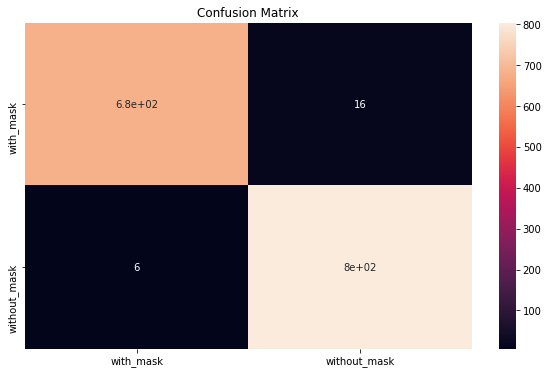

In [ ]:
cf_matrix = confusion_matrix(y_test, pred)
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Confusion Matrix')
plt.show()

# References